# <div style="color:white;display:fill;border-radius:5px;background-color:#1656AD;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">Basic Utiliz + Library Used</div>

In [1]:
%%time

!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

Processing /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
  Preparing metadata (setup.py) ... - done
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=2886506cb2c8a8b9be1932545fa1396c2a90b71f118ba26bf7a96823c571544f
  Stored in directory: /root/.cache/pip/wheels/6b/b5/e0/4c79e15c0b5f2c15ecf613c720bb20daab20a666eb67135155
Successfully built autograd-gamma
Processing /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
Processing /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl
CPU times: user 4.41 s, sys: 948 ms, total: 5.36 s
Wall time: 3min 40s


In [2]:
%%time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import polars as pl
import pandas as pd

from sklearn.base import clone
import optuna
import os
from colorama import Fore

from tqdm import tqdm
from IPython.display import clear_output
from lifelines import KaplanMeierFitter,BreslowFlemingHarringtonFitter,SplineFitter
pd.options.display.max_columns = None
from lifelines.utils import concordance_index


import lightgbm as lgb
from lightgbm import early_stopping  
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn.model_selection import *
from sklearn.metrics import *

SEED = 39
n_splits = 5

CPU times: user 2.63 s, sys: 580 ms, total: 3.21 s
Wall time: 5.2 s


# <div style="color:white;display:fill;border-radius:5px;background-color:#1656AD;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">Load Data + Some Preprocess</div>

In [3]:
%%time

sp = '/kaggle/input/abdbase/AbdML/main.py'
tp = '/kaggle/working/main.py'

with open(sp, 'r', encoding='utf-8') as file:
    content = file.read()
with open(tp, 'w', encoding='utf-8') as file:
    file.write(content)

from main import AbdBase

train = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')
sample = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv')
train_solution = train[['ID','efs','efs_time','race_group']].copy()

cat_c = ['dri_score','psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist',
 'renal_issue','pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type',
 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match',
 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group',
 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac','pulm_moderate']

def update(df):
    
    global cat_c

    for c in cat_c:
        df[c] = df[c].fillna('None').astype('category')

    j_ch=',[]{}:"\\<'
    for ch in j_ch:
        for c in cat_c:
            df[c] = df[c].apply(lambda x:str(x).replace(ch,''))
                
    return df

train = update(train)
test = update(test)

def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = BreslowFlemingHarringtonFitter()
    kmf.fit(df[time_col], event_observed=df[event_col])
    survival_probabilities = kmf.survival_function_at_times(df[time_col]).values.flatten()
    return survival_probabilities

def update_target_with_survival_probabilities(df, time_col='efs_time', event_col='efs'):

    race_group = sorted(df['race_group'].unique())
    survival_probs_dict = {}
    for race in race_group:
        race_df = df[df['race_group'] == race]
        survival_probs_dict[race] = transform_survival_probability(race_df, time_col, event_col)
    for race in race_group:
        df.loc[df['race_group'] == race, 'target'] = survival_probs_dict[race]
    df.loc[df[event_col] == 0, 'target'] -= 0.15
    
    return df

train = update_target_with_survival_probabilities(train, time_col='efs_time', event_col='efs')
train

f_fe = [
    'year_hct', 'dri_score_High', 'comorbidity_score', 'conditioning_intensity_None', 
    'karnofsky_score', 'donor_age', 'age_at_hct', 'mrd_hct_None', 
    'cyto_score_detail_Poor', 'dri_score_Intermediate', 'conditioning_intensity_RIC', 
    'cyto_score_Poor', 'hla_match_a_high', 'prim_disease_hct_ALL', 
    'gvhd_proph_FK+ MMF +- others', 
    'dri_score_High - TED AML case missing cytogenetics', 'sex_match_F-M', 
    'pulm_severe_Yes', 'cmv_status_-/+', 'hla_nmdp_6', 'cardiac_Yes', 
    'race_group_Black or African-American', 'sex_match_M-M', 'prim_disease_hct_AML', 
    'mrd_hct_Negative', 'donor_related_Related', 'hla_match_a_low', 
    'cyto_score_detail_None', 'cyto_score_Favorable', 'sex_match_M-F', 
    'arrhythmia_No', 'prior_tumor_No', 'in_vivo_tcd_Yes', 
    'race_group_More than one race', 'sex_match_F-F', 'hla_match_drb1_high', 
    'donor_related_Unrelated', 'tbi_status_No TBI', 'cyto_score_detail_Favorable', 
    'pulm_severe_No', 'tce_imm_match_None', 'mrd_hct_Positive', 
    'prim_disease_hct_MDS', 'diabetes_Yes', 'cmv_status_+/-', 
    'gvhd_proph_FKalone', 'prior_tumor_Not done', 'melphalan_dose_MEL', 
    'diabetes_No', 'arrhythmia_None', 'gvhd_proph_Cyclophosphamide +- others', 
    'hla_low_res_8', 'gvhd_proph_CSA + MMF +- others(not FK)', 'hepatic_severe_No', 
    'hla_low_res_6', 'graft_type_Bone marrow', 'cmv_status_+/+', 
    'prim_disease_hct_IEA', 'hla_match_dqb1_high', 'hla_match_dqb1_low', 
    'hla_match_b_low', 'dri_score_N/A - pediatric', 'dri_score_TBD cytogenetics', 
    'conditioning_intensity_MAC', 'obesity_No', 'tce_match_None', 
    'in_vivo_tcd_None', 'race_group_White', 'tce_div_match_None', 
    'hla_high_res_10', 'prod_type_BM', 'prim_disease_hct_IIS', 
    'hla_match_c_high', 'hla_match_c_low', 'prod_type_PB', 'hla_low_res_10', 
    'cyto_score_None', 'cmv_status_-/-', 'prior_tumor_Yes', 
    'conditioning_intensity_NMA', 'arrhythmia_Not done', 'cardiac_None', 
    'tce_imm_match_G/G', 'prim_disease_hct_NHL', 'cyto_score_detail_Not tested', 
    'dri_score_Low', 'ethnicity_Not Hispanic or Latino', 'hla_match_b_high', 
    'race_group_Asian', 'melphalan_dose_N/A Mel not given', 'hepatic_mild_None', 
    'psych_disturb_No', 'tbi_status_TBI +- Other =cGy', 
    'cyto_score_detail_Intermediate', 'in_vivo_tcd_No', 'conditioning_intensity_TBD', 
    'hla_match_drb1_low', 'graft_type_Peripheral blood', 'hla_high_res_8', 
    'hla_high_res_6', 'prim_disease_hct_HIS', 'cyto_score_Intermediate', 
    'cyto_score_TBD', 'donor_related_Multiple donor (non-UCB)', 
    'pulm_moderate_Yes', 'tce_imm_match_P/P', 'tbi_status_TBI +- Other >cGy', 
    'vent_hist_Yes', 'tbi_status_TBI + Cy +- Other', 'tce_div_match_HvG non-permissive', 
    'cyto_score_detail_TBD', 'gvhd_proph_Cyclophosphamide alone', 
    'tce_div_match_Permissive mismatched', 'obesity_None', 'tce_match_Permissive', 
    'pulm_severe_None', 'rheum_issue_Yes', 'tce_div_match_GvH non-permissive', 
    'cardiac_No', 'dri_score_Very high', 'diabetes_Not done', 'rituximab_None', 
    'tce_match_GvH non-permissive', 'tce_imm_match_H/H', 'gvhd_proph_None', 
    'prim_disease_hct_SAA', 'rituximab_No', 'vent_hist_No', 'hepatic_severe_Yes', 
    'tce_imm_match_G/B', 'pulm_moderate_No', 'vent_hist_None', 
    'gvhd_proph_TDEPLETION alone', 'dri_score_N/A - non-malignant indication', 
    'race_group_Native Hawaiian or other Pacific Islander', 'prim_disease_hct_PCD', 
    'rheum_issue_Not done', 'cyto_score_Other', 'dri_score_None', 'ethnicity_None', 
    'dri_score_Intermediate - TED AML case missing cytogenetics', 
    'cmv_status_None', 'melphalan_dose_None', 'gvhd_proph_FK+ MTX +- others(not MMF)', 
    'psych_disturb_Yes', 'ethnicity_Hispanic or Latino', 'pulm_severe_Not done', 
    'renal_issue_None', 'peptic_ulcer_No', 'donor_related_None', 
    'prim_disease_hct_AI', 'tbi_status_TBI +- Other -cGy unknown dose', 
    'hepatic_severe_Not done', 'peptic_ulcer_None', 
    'tce_div_match_Bi-directional non-permissive', 'renal_issue_No', 
    'arrhythmia_Yes', 'tce_match_Fully matched', 'pulm_moderate_None', 
    'rituximab_Yes'
]

def c_index_score(modeloff, model_name, weights=None):
    y_true = train_solution 
    y_pred = train_solution[["ID"]].copy()

    if isinstance(modeloff, (list, tuple, np.ndarray)) and all(isinstance(m, np.ndarray) for m in modeloff):
        if weights is None:
            weights = [1] * len(modeloff)
        
        assert len(modeloff) == len(weights), "The number of models must match the number of weights."
        
        combined_modeloff = sum(weight * model for weight, model in zip(weights, modeloff))
        y_pred["prediction"] = combined_modeloff
    else:
        y_pred["prediction"] = modeloff

    c_index = base.CIBMTR_score(y_true.copy(), y_pred.copy(), "ID")
    print(Fore.YELLOW + f"The Score of {model_name} is: {c_index:.4f}")
    
ohe_cols = {'cat_c': cat_c}

base = AbdBase(train_data=train, test_data=test, target_column='target',gpu=False,
                 problem_type="regression", metric="mae", seed=SEED,ohe_fe=ohe_cols,
                 n_splits=10,early_stop=True,num_classes=0,cat_features=None,
                 fold_type='RKF')

base.X_train = base.X_train[f_fe]
base.X_test = base.X_test[f_fe]

def FE(df):
    df['sexmatchsame'] = ((df['sex_match_M-M'] == 1) | (df['sex_match_F-F'] == 1)).astype(int)
    df['age_at_hctmin']=df['year_hct']-df['age_at_hct']
    return df
    
base.X_train = FE(base.X_train)
base.X_test = FE(base.X_test)

*** AbdBase ['V_1.3'] ***

 *** Available Settings *** 

Available Models: LGBM, CAT, XGB, Voting, TABNET, Ridge, LR
Available Metrics: roc_auc, accuracy, f1, precision, recall, rmse, wmae, rmsle, mae, r2, mse, mape, custom
Available Problem Types: classification, regression
Available Fold Types: SKF, KF, GKF, GSKF, RKF

 *** Configuration *** 

Problem Type Selected: REGRESSION
Metric Selected: MAE
Fold Type Selected: RKF
Calculate Train Probabilities: False
Calculate Test Probabilities: False
Early Stopping: True
GPU: False
Eval_Metric Selected is: None

---> Adding OHE Features

CPU times: user 1.58 s, sys: 336 ms, total: 1.91 s
Wall time: 2.53 s


# <div style="color:white;display:fill;border-radius:5px;background-color:#1656AD;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">BaseModels</div>

In [4]:
%%time
CP={'iterations': 5425, 'learning_rate': 0.014371039913552555, 'depth': 6, 'l2_leaf_reg': 0.7055468002158896, 'border_count': 248, 'bagging_temperature': 0.5649412591124418, 'random_strength': 5.721598140617754, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 6, 'max_ctr_complexity': 1}
results_CAT = base.Train_ML(CP,'CAT', e_stop=100)  
c_index_score(results_CAT[0],'CAT_MODEL_OPTIMIZED')

Training Folds: 100%|██████████| 10/10 [04:24<00:00, 26.46s/it]

Overall Train MAE: 0.1579
Overall OOF MAE: 0.1789 


The Score of CAT_MODEL_OPTIMIZED is: 0.6777
CPU times: user 14min 50s, sys: 1min 39s, total: 16min 30s
Wall time: 4min 25s


# <div style="color:white;display:fill;border-radius:5px;background-color:#1656AD;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">Feature Importances</div>

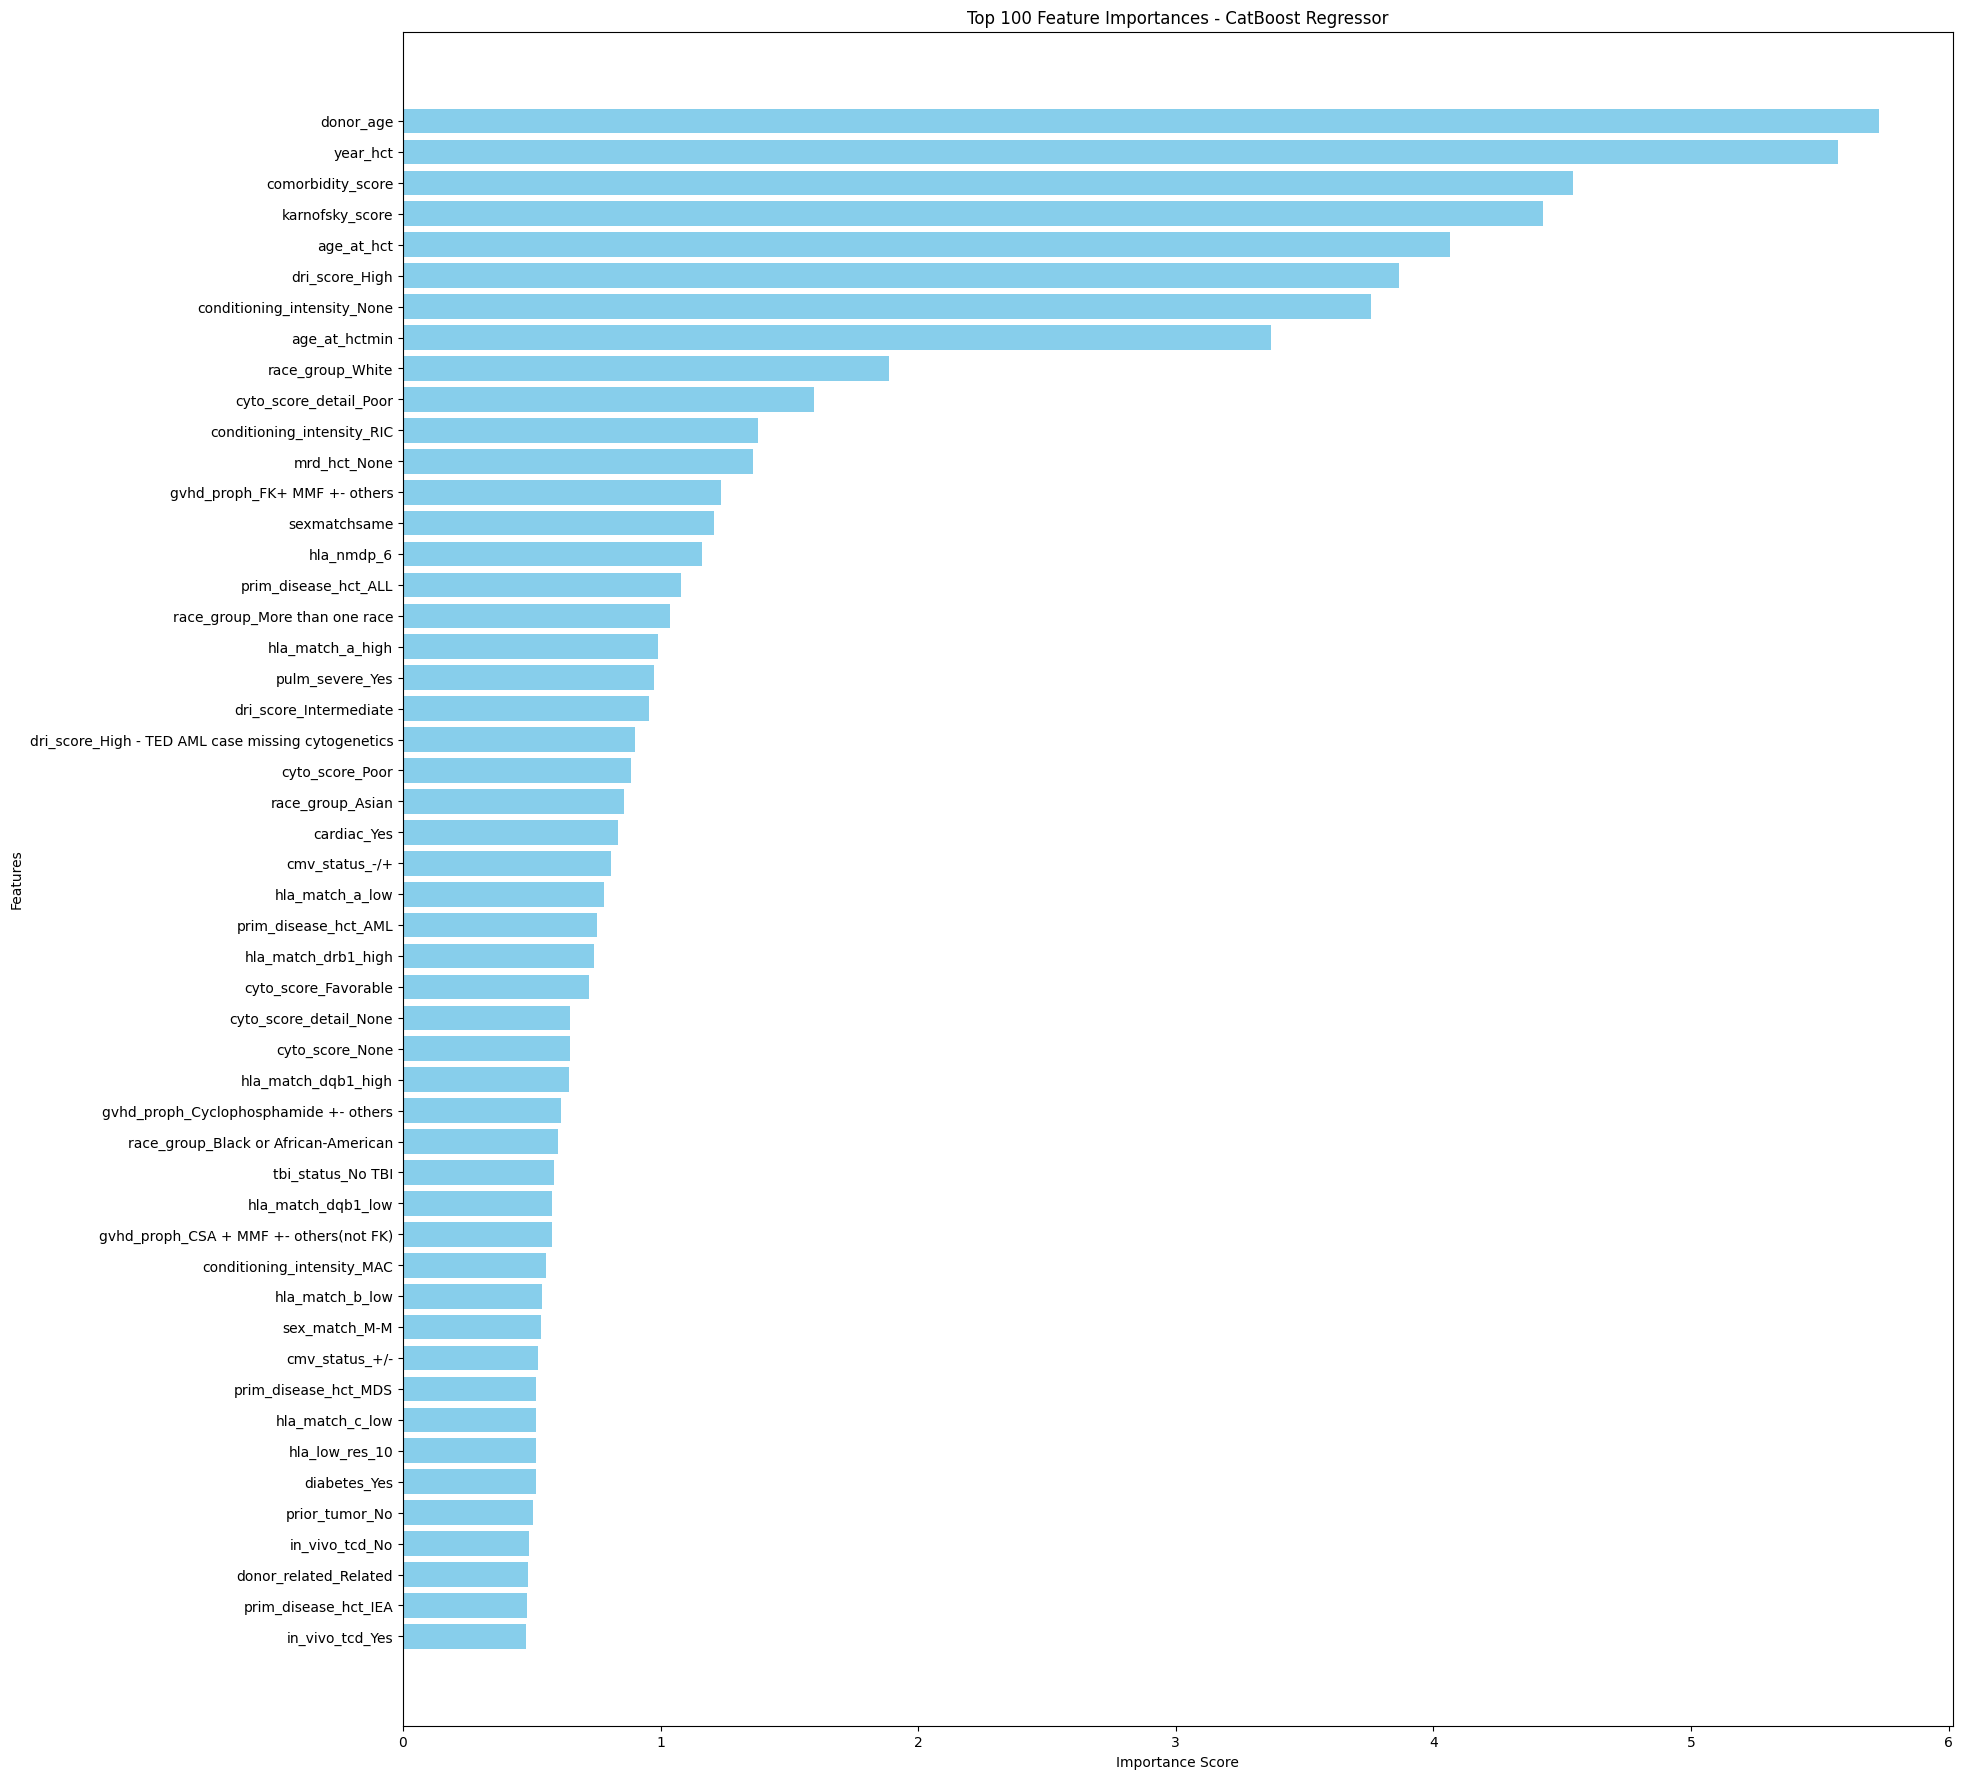

CPU times: user 1.02 s, sys: 264 ms, total: 1.29 s
Wall time: 993 ms


In [5]:
%%time

import matplotlib.pyplot as plt

def cat_fe_imp(model):

    feature_importances = model.get_feature_importance(prettified=True)
    feature_importances = feature_importances.sort_values(by='Importances', ascending=False)
    
    top_features = feature_importances.head(50)
    feature_names = top_features['Feature Id']
    importances = top_features['Importances']
    
    plt.figure(figsize=(20, 22))
    plt.barh(feature_names, importances, color='skyblue')
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.title("Top 100 Feature Importances - CatBoost Regressor")
    plt.gca().invert_yaxis()
    plt.show()

cat_fe_imp(results_CAT[2])

# <div style="color:white;display:fill;border-radius:5px;background-color:#1656AD;text-align:center;letter-spacing:0.1px;overflow:hidden;padding:20px;color:white;overflow:hidden;margin:0;font-size:100%">Submission</div>

In [6]:
%%time
tmp = results_CAT[1]
sample.prediction = tmp
sample.to_csv("submission.csv",index=False)
print("Sub shape:",sample.shape)
sample.head()

Sub shape: (3, 2)
CPU times: user 5.1 ms, sys: 0 ns, total: 5.1 ms
Wall time: 5.34 ms


,ID,prediction
0,28800,0.433615
1,28801,0.623343
2,28802,0.365626
